画像アップ、白黒に、手書き結果を確認すべし
現状画像データ変換後の保存先があやしい

In [0]:
!mkdir DATA
!mkdir DATA/carrot DATA/poteto DATA/sweetpotato

画像データアップロード


In [0]:
import os
from glob import glob                                                           
import cv2

i = 1
jpegs = glob('DATA/carrot/*.jpeg', recursive=True)
for file in jpegs:
      src = file
      dst= "DATA/carrot/" + str(i) + ".jpg"
      os.rename(src,dst)
      i += 1


In [0]:
i = 1
jpegs = glob('DATA/poteto/*.jpeg', recursive=True)
for file in jpegs:
      src = file
      dst= "DATA/poteto/" + str(i) + ".jpg"
      os.rename(src,dst)
      i += 1

In [0]:
i = 1
jpegs = glob('DATA/sweetpotato/*.jpeg', recursive=True)
for file in jpegs:
      src = file
      dst= "DATA/sweetpotato/" + str(i) + ".jpg"
      os.rename(src,dst)
      i += 1

In [0]:
jpgs = glob('./**/*.jpg', recursive=True)

#check if directory exist, if not create it

for j in jpgs:
    #img = glob.glob(j)
    image = cv2.imread(j)
    gray_image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(j[:-3] + 'jpg', gray_image)

In [9]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


import itertools
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pylab as plt

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TensorFlow 2.x selected.
TF version: 2.0.0-rc2
Hub version: 0.6.0
GPU is available


In [10]:
module_selection = ("mobilenet_v2", 224) #@param ["(\"mobilenet_v2\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224)


In [11]:
!mkdir /root/.keras/datasets/
!ls /root/.keras
!cp -r DATA /root/.keras/datasets/
#!ls /root/.keras/datasets/DATA/0

data_root = '/root/.keras/datasets/DATA'

datasets  keras.json


In [12]:
data_root

'/root/.keras/datasets/DATA'

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [0]:
IMAGE_SHAPE = (224, 224)
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [16]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 39 images belonging to 3 classes.


In [17]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 3)


In [18]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [19]:
#なくてもいい？
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [22]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor_layer.trainable = False

In [24]:
# レイヤーの追加
from tensorflow.keras import layers
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
predictions = model(image_batch)

In [27]:
predictions.shape

TensorShape([32, 3])

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [31]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback])

Train for 2.0 steps
Epoch 1/10
2/2 [==============================] - 4s 2s/step - loss: 1.4134 - acc: 0.1429
Epoch 2/10
2/2 [==============================] - 0s 86ms/step - loss: 1.0008 - acc: 0.5714
Epoch 3/10
2/2 [==============================] - 0s 88ms/step - loss: 0.7370 - acc: 0.8125
Epoch 4/10
2/2 [==============================] - 0s 90ms/step - loss: 0.5374 - acc: 1.0000
Epoch 5/10
2/2 [==============================] - 0s 89ms/step - loss: 0.3896 - acc: 0.9062
Epoch 6/10
2/2 [==============================] - 0s 88ms/step - loss: 0.2915 - acc: 0.9062
Epoch 7/10
2/2 [==============================] - 0s 96ms/step - loss: 0.2220 - acc: 0.9062
Epoch 8/10
2/2 [==============================] - 0s 88ms/step - loss: 0.1710 - acc: 0.9062
Epoch 9/10
2/2 [==============================] - 0s 91ms/step - loss: 0.1339 - acc: 0.9688
Epoch 10/10
2/2 [==============================] - 0s 87ms/step - loss: 0.1146 - acc: 1.0000


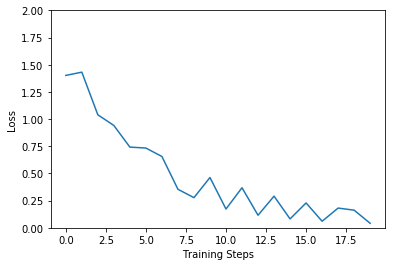

In [32]:
import matplotlib.pylab as plt
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

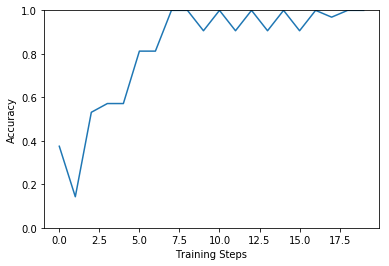

In [33]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [34]:
print("IN: " + str(model.input_shape))
print("OUT: " + str(model.output_shape))

IN: (None, 224, 224, 3)
OUT: (None, 3)


In [35]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Carrot', 'Poteto', 'Sweetpotato'], dtype='<U11')

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [0]:
label_id = np.argmax(label_batch, axis=-1)

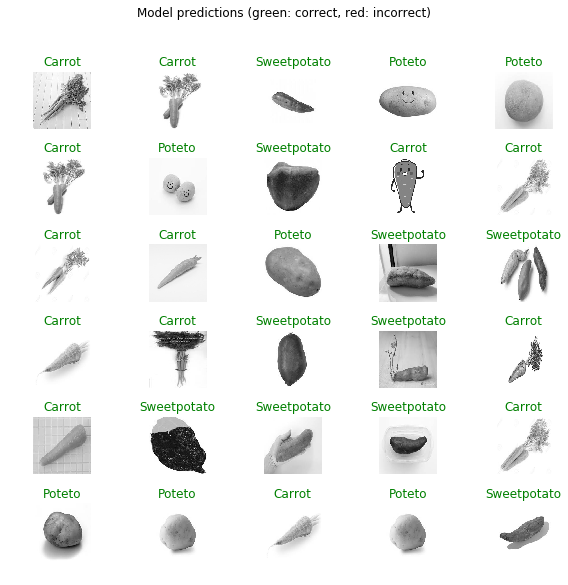

In [38]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [39]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path

Instructions for updating:
Please use `model.save(..., save_format="tf")` or `tf.keras.models.save_model(..., save_format="tf")`.


Instructions for updating:
Please use `model.save(..., save_format="tf")` or `tf.keras.models.save_model(..., save_format="tf")`.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /tmp/saved_models/1570066788/saved_model.pb


INFO:tensorflow:SavedModel written to: /tmp/saved_models/1570066788/saved_model.pb


'/tmp/saved_models/1570066788'

In [40]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

Instructions for updating:
The experimental save and load functions have been  deprecated. Please switch to `tf.keras.models.load_model`.


Instructions for updating:
The experimental save and load functions have been  deprecated. Please switch to `tf.keras.models.load_model`.


In [0]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [42]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [46]:
!ls /tmp/saved_models/1570066788

assets	saved_model.pb	variables


In [47]:
saved_model_path = '/tmp/saved_models/1570066788/'
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /tmp/saved_models/1570066788/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1570066788/assets


In [48]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()
open('vege-b32-01.tflite', 'wb').write(tflite_model)

8890496